In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

df = pd.read_csv("/content/ecommerce_sales_34500.csv")
date_cols = [col for col in df.columns if "date" in col.lower()]
df = df.drop(columns=date_cols)

le_returned = LabelEncoder()
df["returned"] = le_returned.fit_transform(df["returned"].astype(str))

skip_id_cols = ["order_id", "customer_id", "product_id"]
label_encoders = {}
alpha_cols = []

for col in df.columns:
    if col in skip_id_cols or col == "returned":
        continue
    if df[col].dtype == "object":
        has_alpha = df[col].astype(str).str.contains(r"[A-Za-z]", regex=True, na=False).any()
        if has_alpha:
            alpha_cols.append(col)

for col in alpha_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df = df.fillna(df.median(numeric_only=True))

label_col = "returned"
y = df[label_col]
X = df.drop(columns=[label_col])
X_model = X.drop(columns=skip_id_cols, errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, random_state=42, stratify=y
)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

train_smote = pd.DataFrame(X_train_res, columns=X_model.columns)
train_smote[label_col] = y_train_res.values
train_smote.to_csv("ecommerce_train_smote.csv", index=False)

test_df = pd.DataFrame(X_test, columns=X_model.columns)
test_df[label_col] = y_test.values
test_df.to_csv("ecommerce_test.csv", index=False)


In [86]:
# ---------------------------------------------------
# 1. Import Libraries
# ---------------------------------------------------
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

In [87]:
# ---------------------------------------------------------
# Function: Load + Encode Dataset
# ---------------------------------------------------------
def load_and_preprocess(path, target_col):

    df = pd.read_csv(path)

    print(f"\nLoaded: {path}")
    print("Initial Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print(df.head())

    # Separate features and labels
    X = df.drop(columns=[target_col])
    y = df[target_col]

    return X, y

# ---------------------------------------------------------
# 1. Load Training Data
# ---------------------------------------------------------
train_path = "/content/ecommerce_train_smote.csv"
X_train, y_train= load_and_preprocess(train_path, target_col="returned")

print("\nX_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



Loaded: /content/ecommerce_train_smote.csv
Initial Shape: (52156, 13)
Columns: ['category', 'price', 'discount', 'quantity', 'payment_method', 'delivery_time_days', 'region', 'total_amount', 'shipping_cost', 'profit_margin', 'customer_age', 'customer_gender', 'returned']
   category   price  discount  ...  customer_age  customer_gender  returned
0         4  341.15      0.00  ...            29                0         1
1         3    5.05      0.10  ...            36                0         0
2         6    2.31      0.05  ...            51                0         0
3         5   44.85      0.00  ...            47                0         0
4         1  292.03      0.00  ...            30                1         0

[5 rows x 13 columns]

X_train shape: (52156, 12)
y_train shape: (52156,)


In [88]:
neg_class = sum(y_train == 0)
pos_class = sum(y_train == 1)
scale_pos_weight = neg_class / pos_class

In [89]:
# ---------------------------------------------------
# 7. Train XGBoost Model
# ---------------------------------------------------
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.09,
    max_depth=20,
    subsample=0.9,
    colsample_bytree=0.5,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    objective="binary:logistic"
)

model.fit(X_train, y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [91]:
test_path = "/content/ecommerce_test.csv"
X_test,y_test = load_and_preprocess(test_path, target_col="returned")
# ---------------------------------------------------
# 8. Predictions
# ---------------------------------------------------
y_pred = model.predict(X_test)

# ---------------------------------------------------
# 9. Evaluation
# ---------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['not_returned', 'returned'],digits=4))


Loaded: /content/ecommerce_test.csv
Initial Shape: (6900, 13)
Columns: ['category', 'price', 'discount', 'quantity', 'payment_method', 'delivery_time_days', 'region', 'total_amount', 'shipping_cost', 'profit_margin', 'customer_age', 'customer_gender', 'returned']
   category   price  discount  ...  customer_age  customer_gender  returned
0         1  249.33      0.05  ...            26                2         0
1         0   24.12      0.00  ...            27                0         0
2         1  120.43      0.30  ...            36                1         0
3         4  108.57      0.05  ...            53                0         1
4         6    2.90      0.00  ...            67                0         0

[5 rows x 13 columns]

Confusion Matrix:
 [[6373  146]
 [ 368   13]]

Accuracy: 0.9255072463768116

Classification Report:

              precision    recall  f1-score   support

not_returned     0.9454    0.9776    0.9612      6519
    returned     0.0818    0.0341    0.0481  

ROC-AUC Score: 0.5764430159529644


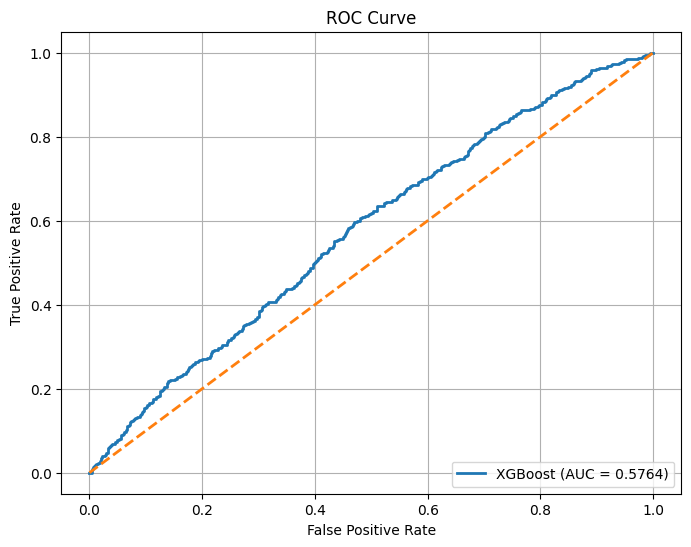

In [92]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1. Get predicted probabilities (for positive class = 1)
# --------------------------------------------------------
y_prob = model.predict_proba(X_test)[:, 1]

# --------------------------------------------------------
# 2. Compute ROC curve and AUC
# --------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print("ROC-AUC Score:", roc_auc)

# --------------------------------------------------------
# 3. Plot ROC Curve
# --------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"XGBoost (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [93]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import numpy as np

# ------------------------------------------------------------
# 1. Get predicted probabilities for the positive class
# ------------------------------------------------------------
y_prob = model.predict_proba(X_test)[:, 1]


best_threshold = 0.002
print("Best Threshold:",best_threshold)

# ------------------------------------------------------------
# 4. Apply best threshold to predictions
# ------------------------------------------------------------
y_pred_best = (y_prob >= threshold).astype(int)

# ------------------------------------------------------------
# 5. Compute Classification Metrics at Optimal Threshold
# ------------------------------------------------------------
print("\n===== METRICS USING OPTIMAL THRESHOLD =====")
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1-score:", f1_score(y_test, y_pred_best))




Best Threshold: 0.002

===== METRICS USING OPTIMAL THRESHOLD =====
Precision: 0.06273553535801374
Recall: 0.7427821522309711
F1-score: 0.11569910057236305


In [97]:
model.save_model("xgb_model.json")

In [98]:
# ================================
# 🔹 Gradio UI for XGBoost Model
# ================================
!pip install gradio -q

import gradio as gr
import numpy as np
import pandas as pd

# Use the same feature columns as training
feature_columns = list(X_train.columns)

# Precompute means to handle missing values in user input (if any)
feature_means = X_train.mean()

def predict_return(user_df):
    """Return predicted class + probability for class 1."""

    if user_df is None or len(user_df) == 0:
        return "⚠ Please enter values for all features."

    # Create a copy
    df_input = user_df.copy()

    # Keep columns in correct order
    df_input = df_input[feature_columns]

    # Convert to numeric (VERY IMPORTANT)
    df_input = df_input.apply(pd.to_numeric, errors='coerce')

    # Fill missing values
    df_input = df_input.fillna(feature_means)

    # Get both class probabilities
    probs = model.predict_proba(df_input)[0]
    prob_not_returned = float(probs[0])
    prob_returned = float(probs[1])

    # Use simple 0.50 threshold
    pred_label = int(prob_returned >= 0.50)

    status = "Returned" if pred_label == 1 else "Not Returned"

    msg = f"""
# 🔮 Prediction Result

### 🏷 Predicted Class: **{status}**
(Using threshold = 0.50)

---

## 📊 Confidence Scores

### ✅ **Not Returned (Class 0): `{prob_not_returned*100:.2f}%`**
### ❗ **Returned (Class 1): `{prob_returned*100:.2f}%`**

---
"""

    return msg


# Gradio DataFrame input
input_df = gr.Dataframe(
    headers=feature_columns,
    row_count=1,
    col_count=(len(feature_columns), "fixed"),
    datatype=["number"] * len(feature_columns),
    label="Enter values for each feature"
)

output_text = gr.Markdown(label="Prediction Output")

demo = gr.Interface(
    fn=predict_return,
    inputs=input_df,
    outputs=output_text,
    title="🛒 E-commerce Order Return Prediction (XGBoost)",
    description="Enter feature values to get return probability.",
    allow_flagging="never"
)

demo.launch()


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c883e3533d23bc6e25.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
